/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')


Using TensorFlow backend.


float64 (196, 4, 240, 240) 0.0 11.099523639678956 0.8426226904531355


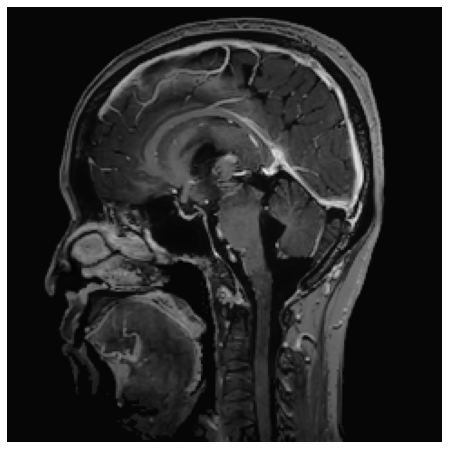

In [1]:
%reload_ext autoreload
%autoreload 2

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (10, 8)

from subtle.dnn.generators import GeneratorUNet2D, GeneratorBranchUNet2D, GeneratorFBoostUNet2D
import subtle.utils.io as suio
from subtle.data_loaders.slice_loader import SliceLoader
import subtle.subtle_loss as suloss
from subtle.dnn.helpers import clear_keras_memory, set_keras_memory
from keras.optimizers import Adam

from keract import get_activations, display_activations, display_heatmaps
from keras.utils.vis_utils import plot_model

def show_img(img, title='', axis=False, vmin=None, vmax=None, cmap='gray'):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args, cmap=cmap)
    plt.title(title, fontsize=15)

def iminfo(img):
    print(img.shape, img.dtype, img.min(), img.max(), img.mean())

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.set_cmap('gray')

npy_file = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO57.h5'

study_data = suio.load_file(npy_file, params={'h5_key': 'all'})[0]

print(study_data.dtype, study_data.shape, study_data.min(), study_data.max(), study_data.mean())
show_img(study_data[98, 2, :, :])

In [2]:
clear_keras_memory()
set_keras_memory(1.0)

loss_function = suloss.mixed_loss(l1_lambda=1.0, ssim_lambda=0.0)
metrics_monitor = [suloss.l1_loss]

model = GeneratorFBoostUNet2D(
            num_channel_input=35, num_channel_output=1,
            img_rows=240, img_cols=240,
            loss_function=loss_function,
            metrics_monitor=metrics_monitor,
            lr_init=0.001,
            verbose=2,
            compile_model=True,
            model_config='t1pre_1ch',
            transfer_weights=True,
            fpaths_pre=[
                '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/enh_vgg.checkpoint',
                '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/fboost_t1_t2.checkpoint',
                '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/fboost_t1_fl.checkpoint',
                '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/fboost_t1_uad.checkpoint',
                '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/enh_vgg_1ch_sc.checkpoint'
            ])
#             checkpoint_file='/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/fboost_super_ilv_t1pre_1ch/weights-35-3.46.checkpoint')
model.load_weights()



Building fboost_unet2d-t1pre_1ch model...
inputs Tensor("model_input:0", shape=(?, 240, 240, 35), dtype=float32)
Building branch_unet2d-fusion_t1pre_final_1ch model...
inputs Tensor("model_input_1:0", shape=(?, 240, 240, 35), dtype=float32)
t1 pre Tensor("t1_pre_1/strided_slice:0", shape=(?, 240, 240, 7), dtype=float32)
t1 low Tensor("t1_low_1/strided_slice:0", shape=(?, 240, 240, 7), dtype=float32)
t2 Tensor("t2_1/strided_slice:0", shape=(?, 240, 240, 7), dtype=float32)
fl Tensor("fl_1/strided_slice:0", shape=(?, 240, 240, 7), dtype=float32)
uad Tensor("uad_1/strided_slice:0", shape=(?, 240, 240, 7), dtype=float32)

Tensor("relu_b1_conv_enc_1_2/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("b1_maxpool_1/MaxPool:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("relu_b1_conv_enc_2_2/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("b1_maxpool_2/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("relu_b1_conv_enc_3_2/Relu:0", shape=(?, 60, 60, 128), dtype=float

Tensor("relu_conv_enc_2_2/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("maxpool_2/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("relu_conv_enc_3_2/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("maxpool_3/MaxPool:0", shape=(?, 30, 30, 128), dtype=float32)
conv center before add Tensor("relu_conv_center/Relu:0", shape=(?, 30, 30, 128), dtype=float32)
conv center... Tensor("add_center/add:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("relu_conv_dec_2_2/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("cat_1/concat:0", shape=(?, 60, 60, 256), dtype=float32)
Tensor("relu_conv_dec_3_2/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("cat_2/concat:0", shape=(?, 120, 120, 192), dtype=float32)
Tensor("relu_conv_dec_4_2/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("cat_3/concat:0", shape=(?, 240, 240, 96), dtype=float32)
Tensor("linear_model_output_1/Identity:0", shape=(?, 240, 240, 1), dtype=float32)
Model: "model_2"
___________________

Transferring weights -> b1_ from /home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/enh_vgg.checkpoint
Building unet2d model...
Tensor("model_input_3:0", shape=(?, 240, 240, 14), dtype=float32)
Tensor("relu_conv_enc_1_2_1/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("maxpool_1_1/MaxPool:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("relu_conv_enc_2_2_1/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("maxpool_2_1/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("relu_conv_enc_3_2_1/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("maxpool_3_1/MaxPool:0", shape=(?, 30, 30, 128), dtype=float32)
conv center before add Tensor("relu_conv_center_1/Relu:0", shape=(?, 30, 30, 128), dtype=float32)
conv center... Tensor("add_center_1/add:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("relu_conv_dec_2_2_1/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("cat_1_1/concat:0", shape=(?, 60, 60, 256), dtype=float32)
Tensor("relu_conv_dec_3_2_1/

Transferring weights -> b2_ from /home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/fboost_t1_t2.checkpoint
Building unet2d model...
Tensor("model_input_4:0", shape=(?, 240, 240, 14), dtype=float32)
Tensor("relu_conv_enc_1_2_2/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("maxpool_1_2/MaxPool:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("relu_conv_enc_2_2_2/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("maxpool_2_2/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("relu_conv_enc_3_2_2/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("maxpool_3_2/MaxPool:0", shape=(?, 30, 30, 128), dtype=float32)
conv center before add Tensor("relu_conv_center_2/Relu:0", shape=(?, 30, 30, 128), dtype=float32)
conv center... Tensor("add_center_2/add:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("relu_conv_dec_2_2_2/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("cat_1_2/concat:0", shape=(?, 60, 60, 256), dtype=float32)
Tensor("relu_conv_dec_3

Transferring weights -> b3_ from /home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/fboost_t1_fl.checkpoint
Building unet2d model...
Tensor("model_input_5:0", shape=(?, 240, 240, 14), dtype=float32)
Tensor("relu_conv_enc_1_2_3/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("maxpool_1_3/MaxPool:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("relu_conv_enc_2_2_3/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("maxpool_2_3/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("relu_conv_enc_3_2_3/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("maxpool_3_3/MaxPool:0", shape=(?, 30, 30, 128), dtype=float32)
conv center before add Tensor("relu_conv_center_3/Relu:0", shape=(?, 30, 30, 128), dtype=float32)
conv center... Tensor("add_center_3/add:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("relu_conv_dec_2_2_3/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("cat_1_3/concat:0", shape=(?, 60, 60, 256), dtype=float32)
Tensor("relu_conv_dec_3

Transferring weights -> b4_ from /home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/fboost_t1_uad.checkpoint
Building unet2d model...
Tensor("model_input_6:0", shape=(?, 240, 240, 2), dtype=float32)
Tensor("relu_conv_enc_1_2_4/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("maxpool_1_4/MaxPool:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("relu_conv_enc_2_2_4/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("maxpool_2_4/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("relu_conv_enc_3_2_4/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("maxpool_3_4/MaxPool:0", shape=(?, 30, 30, 128), dtype=float32)
conv center before add Tensor("relu_conv_center_4/Relu:0", shape=(?, 30, 30, 128), dtype=float32)
conv center... Tensor("add_center_4/add:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("relu_conv_dec_2_2_4/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("cat_1_4/concat:0", shape=(?, 60, 60, 256), dtype=float32)
Tensor("relu_conv_dec_3

Transferring weights -> fbst_ from /home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/enh_vgg_1ch_sc.checkpoint
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        (None, 240, 240, 35) 0                                            
__________________________________________________________________________________________________
t1_pre (Lambda)                 (None, 240, 240, 7)  0           model_input[0][0]                
__________________________________________________________________________________________________
t1_low (Lambda)                 (None, 240, 240, 7)  0           model_input[0][0]                
__________________________________________________________________________________________________
t2 (Lambda)                     (None, 240, 240, 7)  0           mo

Instructions for updating:
ksizes is deprecated, use sizes instead

loading weights from None


/home/srivathsa/projects/SubtleGad/train/subtle/dnn/generators/base.py:149: UserWarning: failed to load weights. training from scratch
  warn('failed to load weights. training from scratch')
/home/srivathsa/projects/SubtleGad/train/subtle/dnn/generators/base.py:150: UserWarning: expected str, bytes or os.PathLike object, not NoneType
  warn(str(e))


In [3]:
prediction_generator = SliceLoader(
    data_list=['/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_t2_fl/NO57.h5'],
    file_ext='h5',
    input_idx=[0, 1],
    output_idx=[2],
    batch_size=8,
    shuffle=False,
    verbose=0,
    residual_mode=False,
    slices_per_input=7,
    num_channel_output=1,
    resize=240,
    slice_axis=[0],
    brain_only=False,
    predict=False,
    use_enh_uad=False,
    use_uad_ch_input=False,
    use_enh_mask=True,
    multi_slice_gt=True,
    uad_ip_channels=7,
    brain_only_mode=None,
    enh_mask_t2=False,
    enh_pfactor=1,
    fpath_uad_masks=['/home/srivathsa/projects/studies/gad/tiantan/preprocess/uad_masks_fl/NO57.npy'],
    uad_file_ext='npy'
)

In [4]:
X, Y = prediction_generator.__getitem__(5)
print(X.shape, Y.shape)

(8, 240, 240, 14) (8, 240, 240, 14)


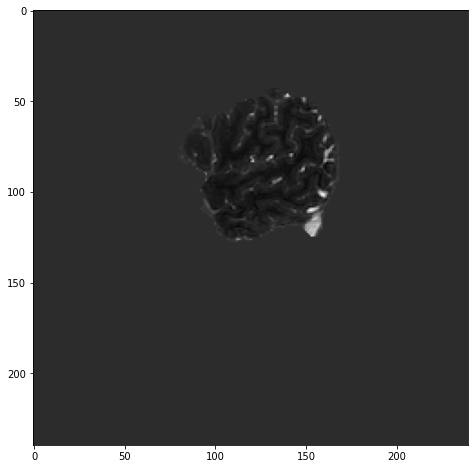

In [14]:
plt.imshow(Y[0, ..., ])

In [ ]:
gen_item = prediction_generator.__getitem__(100)[0][0]
gen_slice = gen_item[:, :, 0]
print('gen info', gen_slice.dtype, gen_slice.shape, gen_slice.min(), gen_slice.max(), gen_slice.mean())
show_img(gen_slice)

In [ ]:
y_pred = model.model.predict_generator(
    generator=prediction_generator,
    max_queue_size=16,
    workers=1,
    use_multiprocessing=False,
    verbose=1
)
print(y_pred.shape)

In [ ]:
plt.imshow(y_pred[90, ..., 0])

In [ ]:
y_pred_sum = np.sum(y_pred, axis=3)
pre_con = study_data[:, 0]
pre_con = np.interp(pre_con, (pre_con.min(), pre_con.max()), (y_pred_sum.min(), y_pred_sum.max()))

In [ ]:
show_img(np.abs(y_pred_sum[113] - pre_con[113]))
plt.colorbar()

In [ ]:
sl = 113
net_ip, _ = prediction_generator.__getitem__(sl)
lnames = ['t1_pre_sl', 'fusion_boost_avg']
t1_pre_sl = get_activations(model.model, net_ip, layer_name=lnames[0])[lnames[0]]#[0, ..., 0]
fboost_avg = get_activations(model.model, net_ip, layer_name=lnames[1])[lnames[1]]#[0, ..., 0]

print(t1_pre_sl.shape, fboost_avg.shape)


# plt.imshow(np.hstack([fboost_avg - t1_pre_sl]))
# plt.colorbar()
t1_pre_sl = np.interp(t1_pre_sl, (t1_pre_sl.min(), t1_pre_sl.max()), (study_data[sl, 0].min(), study_data[sl, 0].max()))
fboost_avg = np.interp(fboost_avg, (fboost_avg.min(), fboost_avg.max()), (study_data[sl, 1].min(), study_data[sl, 1].max()))
t1_ip = np.concatenate((t1_pre_sl, fboost_avg), axis=3)

In [ ]:
t1_model = GeneratorUNet2D(
            num_channel_input=2, num_channel_output=1,
            img_rows=240, img_cols=240,
            loss_function=loss_function,
            metrics_monitor=metrics_monitor,
            lr_init=0.001,
            verbose=2,
            compile_model=True,
            model_config='base',
            checkpoint_file='/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/enh_vgg_1ch.checkpoint')
t1_model.load_weights()

In [ ]:
t1_op = t1_model.model.predict(t1_ip)
plt.imshow(np.hstack([study_data[113, 1], t1_op[0, ..., 0], study_data[113, 2]]))

In [ ]:
plt.imshow(np.hstack([study_data[sl, 0], t1_pre_sl[0, ..., 0]]))

In [ ]:
# study_data = suio.load_h5_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO57.h5')

# net_ip = np.transpose(np.concatenate([study_data[90:97, 0], study_data[90:97, 1]]), (1, 2, 0))
# net_ip = np.array([net_ip])

layer_names = [l.name for l in model.model.layers]
# print(layer_names)

net_ip, _ = prediction_generator.__getitem__(90)
# show_img(net_ip[0, ..., 0])
lname = 'fusion_boost_avg'

activations = get_activations(model.model, net_ip, layer_name=lname)[lname]
print(activations.shape)

plt.imshow(activations[0, ..., 0] - net_ip[0, ..., 15])

# activ_pool = np.sum(activations, axis=3)
# np.save('/home/srivathsa/projects/act_pool_2.npy', activ_pool)
# show_img(activ_pool[0])

# activations = sorted(activations.items(), key=lambda act: layer_names.index(act[0].split(':')[0].split('/')[0]))

# for act in activations:
#     print(act[0], act[1].shape)

In [ ]:
ip_sl = net_ip[0, ..., 0]

lhs = ip_sl[:, :120]
rhs = np.flip(ip_sl[:, 120:], axis=1)
diff = lhs - rhs
show_img(diff > 2)

In [ ]:
act1 = np.load('/home/srivathsa/projects/act_pool_1.npy')
act2 = np.load('/home/srivathsa/projects/act_pool_2.npy')
act1 = (act1 - act1.min()) / act1.max()
act2 = (act2 - act2.min()) / act2.max()
print(act1.min(), act1.max())
print(act2.min(), act2.max())

show_img(np.hstack([act1[0], act2[0]]))

In [ ]:
act_subset = []
keywords = ['max_pooling', 'up_sampling', 'add_1']
for layer_name, activation in activations:
    kw_exists = np.sum([1 if kw in layer_name else 0 for kw in keywords]) > 0
    if kw_exists:
        print(layer_name, activation.shape)
        act_subset.append({layer_name: activation})

In [ ]:
act_idx = 0
key = list(act_subset[act_idx].keys())[0]
activ_0 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 31, 1)):
    show_img(activ_0[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 1
key = list(act_subset[act_idx].keys())[0]
activ_1 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 63, 1)):
    show_img(activ_1[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 2
key = list(act_subset[act_idx].keys())[0]
activ_2 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 127, 1)):
    show_img(activ_2[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 3
key = list(act_subset[act_idx].keys())[0]
activ_3 = act_subset[act_idx][key][0]


pool = np.sum(activ_3, axis=2)

t1 = pool.max() * 0.15
t2 = pool.max() * 0.75
th_img = np.logical_and((pool > t1), (pool < t2))


show_img(pool)

# @interact
# def show_act(idx=(0, 127, 1)):
#     show_img(activ_3[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 4
key = list(act_subset[act_idx].keys())[0]
activ_4 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 127, 1)):
    show_img(activ_4[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 5
key = list(act_subset[act_idx].keys())[0]
activ_5 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 63, 1)):
    show_img(activ_5[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 6
key = list(act_subset[act_idx].keys())[0]
activ_6 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 31, 1)):
    show_img(activ_6[:, :, idx], title=key, cmap='afmhot')

In [ ]:
display_heatmaps(act_subset[1], study_data[168, 2])

In [ ]:
display_heatmaps(act_subset[6], study_data[168, 2])

In [ ]:
t1_pre = study_data[110:117, 0].transpose(1, 2, 0)[None, ...]
t1_low = study_data[110:117, 1].transpose(1, 2, 0)[None, ...]

nx = 240
ny = 240
nc = 14

ileave = lambda ip: np.concatenate((ip[0], ip[1]), axis=0).transpose(1, 2, 3, 0)[None, ...].reshape(-1, nx, ny, nc)

print(ileave([t1_pre, t1_low]).shape)